In [12]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [13]:
base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'

In [14]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [15]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
  tmp_path = os.path.join(base_path, ds_fname)
  key = ds_fname.split('.')[0]
  
  tmp_df = pd.read_csv(tmp_path, header=None)
  prn_li = []
  for i in range(8):
    prn_li.append(int(tmp_df.iloc[1, 11*i+1]))
  globals()[f'{key}_dict'] = {
      int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:9].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:20].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:31].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:42].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:53].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:64].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:75].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:86].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      'prn' : prn_li
  }

dicts = [cs_dict, ds1_dict, ds2_dict, ds3_dict, ds4_dict, ds7_dict, ds8_dict]

In [16]:
cs_dict[cs_dict['prn'][0]]

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz
100,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0
...,...,...,...,...
3332,0.0,0.0,0.0,0.0
3333,0.0,0.0,0.0,0.0
3334,0.0,0.0,0.0,0.0
3335,0.0,0.0,0.0,0.0


In [17]:
def compare(ds_dict, prn, key):
  plt.figure(figsize=(16,5))
  plt.subplot(1,2,1)
  plt.title('CleanStatic')
  plt.plot(cs_dict[cs_dict['prn'][prn]][key])

  plt.subplot(1,2,2)
  plt.title('Spoofed')
  plt.plot(ds_dict[ds_dict['prn'][prn]][key])

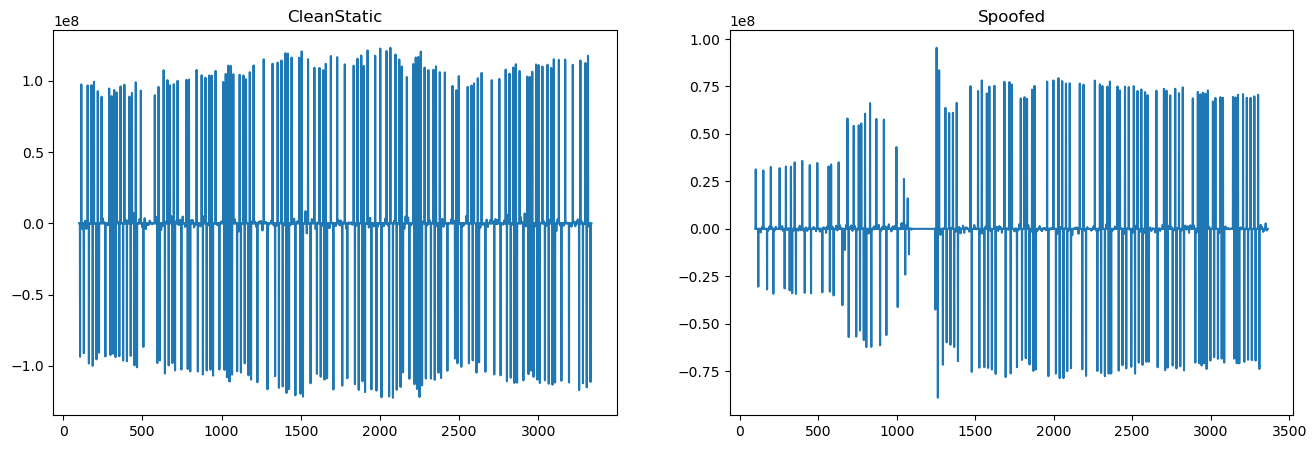

In [18]:
compare(ds3_dict, 1, 'prompt_i')

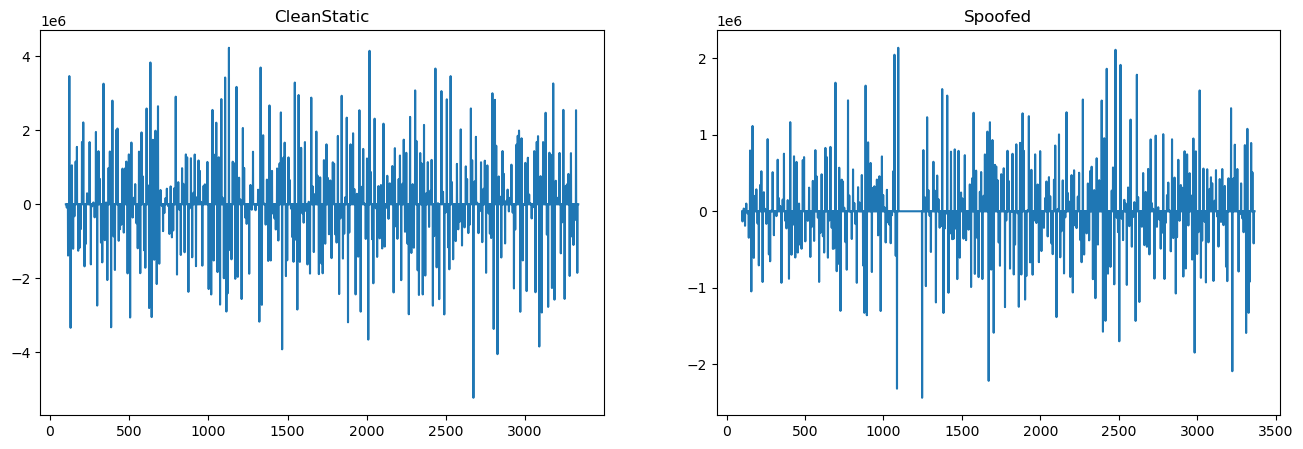

In [19]:
compare(ds3_dict, 1, 'prompt_q')

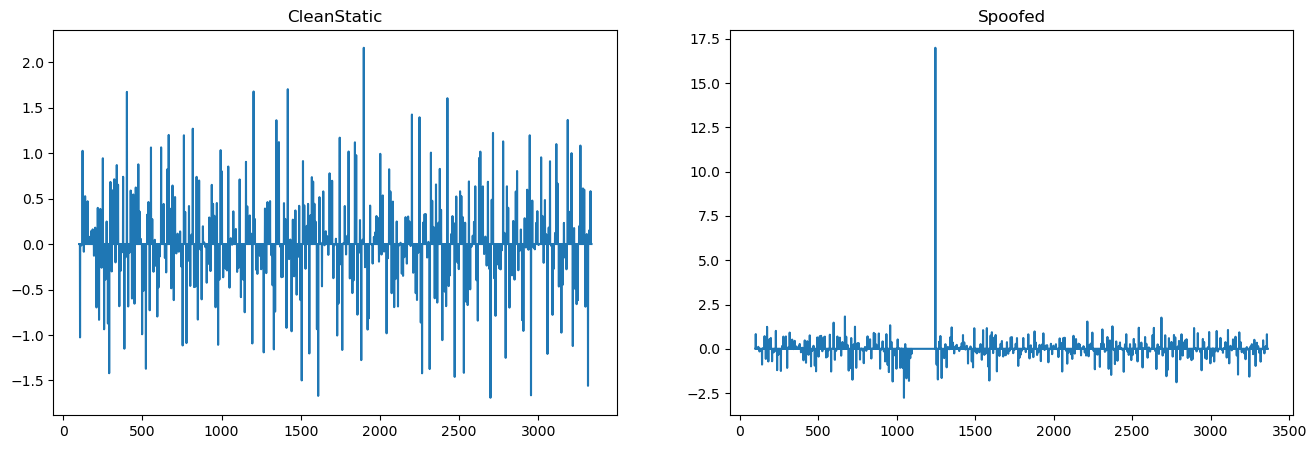

In [20]:
compare(ds3_dict, 1, 'cn0_db_hz')

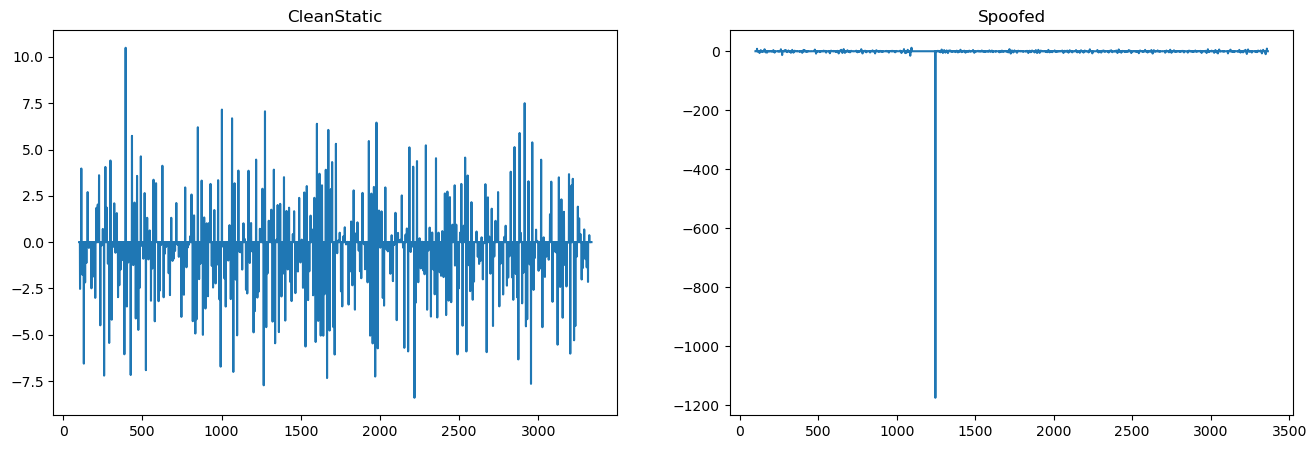

In [21]:
compare(ds3_dict, 1, 'carrier_doppler_hz')

In [22]:
for dic in dicts:
  for prn in list(dic.keys())[:-1]:
    df = dic[prn]
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    dic[prn] = pd.DataFrame(data=df_scaled, index=df.index, columns=df.columns)

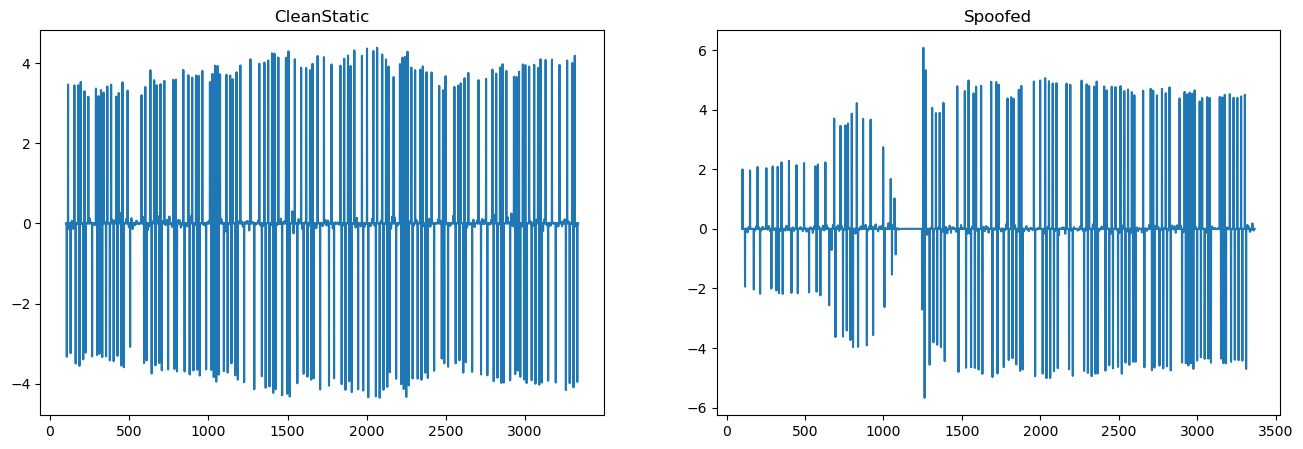

In [23]:
compare(ds3_dict, 1, 'prompt_i')

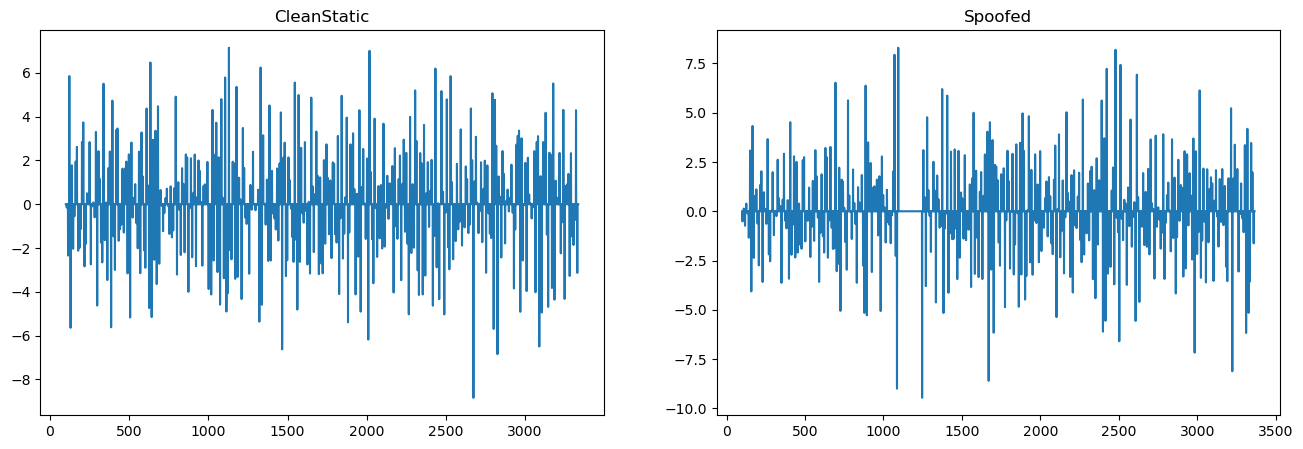

In [24]:
compare(ds3_dict, 1, 'prompt_q')

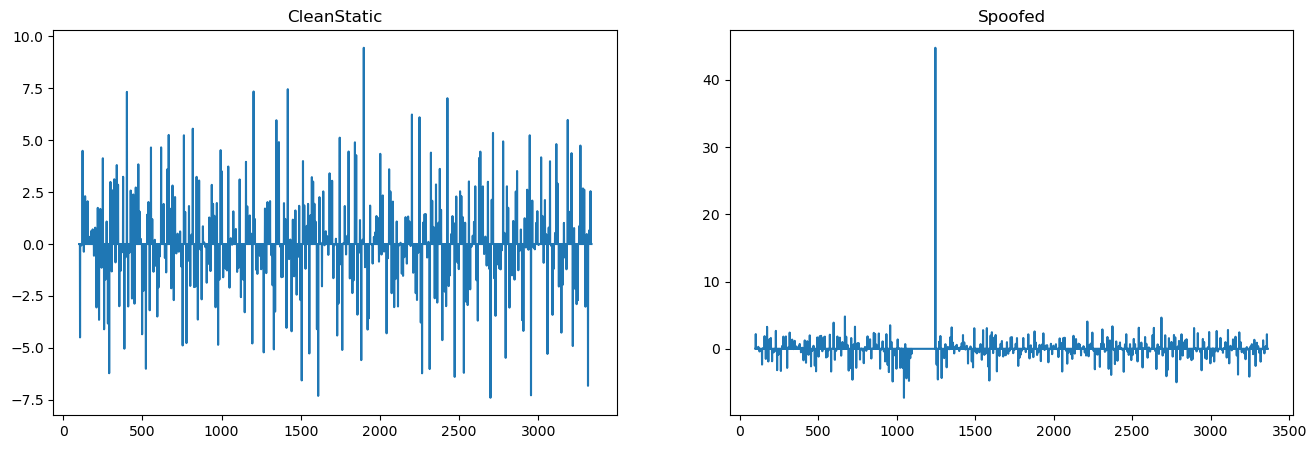

In [25]:
compare(ds3_dict, 1, 'cn0_db_hz')

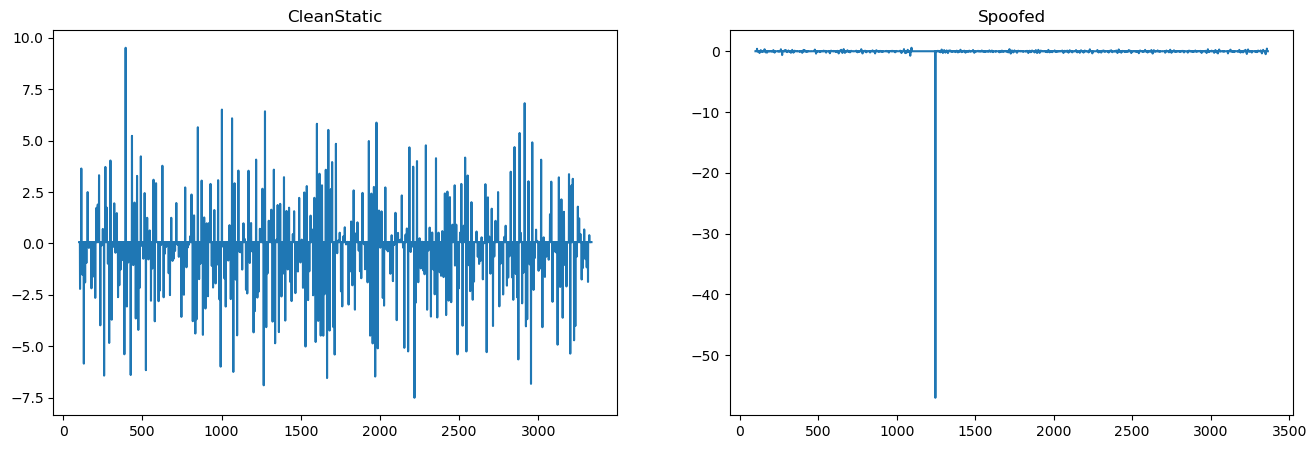

In [26]:
compare(ds3_dict, 1, 'carrier_doppler_hz')

In [27]:
X_train = pd.concat([cs_dict[3], cs_dict[6], cs_dict[7], cs_dict[10], cs_dict[13], cs_dict[16], cs_dict[19], cs_dict[23]]).reset_index().drop('index', axis=1)
X_train.shape

(25896, 4)

In [28]:
X_train

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz
0,-0.001138,0.001133,0.000853,0.124111
1,-0.001138,0.001133,0.000853,0.124111
2,-0.001138,0.001133,0.000853,0.124111
3,-0.001138,0.001133,0.000853,0.124111
4,-0.001138,0.001133,0.000853,0.124111
...,...,...,...,...
25891,-0.000015,0.000340,-0.000699,0.117511
25892,-0.000015,0.000340,-0.000699,0.117511
25893,-0.000015,0.000340,-0.000699,0.117511
25894,-0.000015,0.000340,-0.000699,0.117511


In [29]:
def AutoEncoder_model():
  inputs = Input(shape=(4,))
  encoder1 = Dense(3, activation='tanh')(inputs)
  encoder2 = Dense(2, activation='tanh')(encoder1)
  decoder1 = Dense(3, activation='tanh')(encoder2)
  decoder2 = Dense(4, activation='tanh')(decoder1)
  outputs = Dense(4, activation='softmax')(decoder2)
  model = Model(inputs, outputs)
  model.compile(optimizer='adam',loss='mean_squared_error')
  return model

autoencoder = AutoEncoder_model()

In [30]:
autoencoder.fit(X_train, X_train, epochs = 100, batch_size=128,
validation_data=(X_train, X_train))

Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1130 - val_loss: 1.0379
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.9896 - val_loss: 1.0011
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.9607 - val_loss: 0.9875
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.9587 - val_loss: 0.9819
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.9770 - val_loss: 0.9794
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9858 - val_loss: 0.9777
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.9709 - val_loss: 0.9763
Epoch 8/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.9807 - val_loss: 0.9744
Epoch 9/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.9982 - val_loss: 0.9692
Epoch 10/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.9811 - val_loss: 0.9597
Epoch 11/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.9577 - val_loss: 0.9521
Epoch 12/100
203/203 ━━

810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


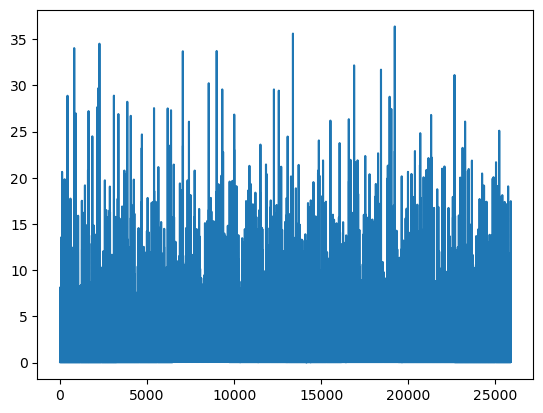

In [31]:
X_prd = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - X_prd, 2), axis=1)
plt.plot(mse)

In [32]:
def run_detector(ds_dict, prn, visualize=False):
  prd = autoencoder.predict(ds_dict[prn].diff().fillna(0))
  mse = np.mean(np.power(ds_dict[prn] - prd, 2), axis=1)
  if visualize:
    plt.plot(mse)
  return mse

In [33]:
def cal_mse(dic):
  result = []
  for prn in dic['prn']:
    prd = autoencoder.predict(dic[prn])
    mse = np.mean(np.power(dic[prn] - prd, 2), axis=1)
    result.append(mse)
  return result

In [34]:
cs_mse = cal_mse(cs_dict)
ds1_mse = cal_mse(ds1_dict)
ds2_mse = cal_mse(ds2_dict)
ds3_mse = cal_mse(ds3_dict)
ds4_mse = cal_mse(ds4_dict)
ds7_mse = cal_mse(ds7_dict)
ds8_mse = cal_mse(ds8_dict)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
106/106 ━━━

In [35]:
def vis_mse(ds_mse):
  plt.figure(figsize=(20,7))
  for i in range(8):
    plt.subplot(2,4,i+1)
    plt.plot(ds_mse[i])

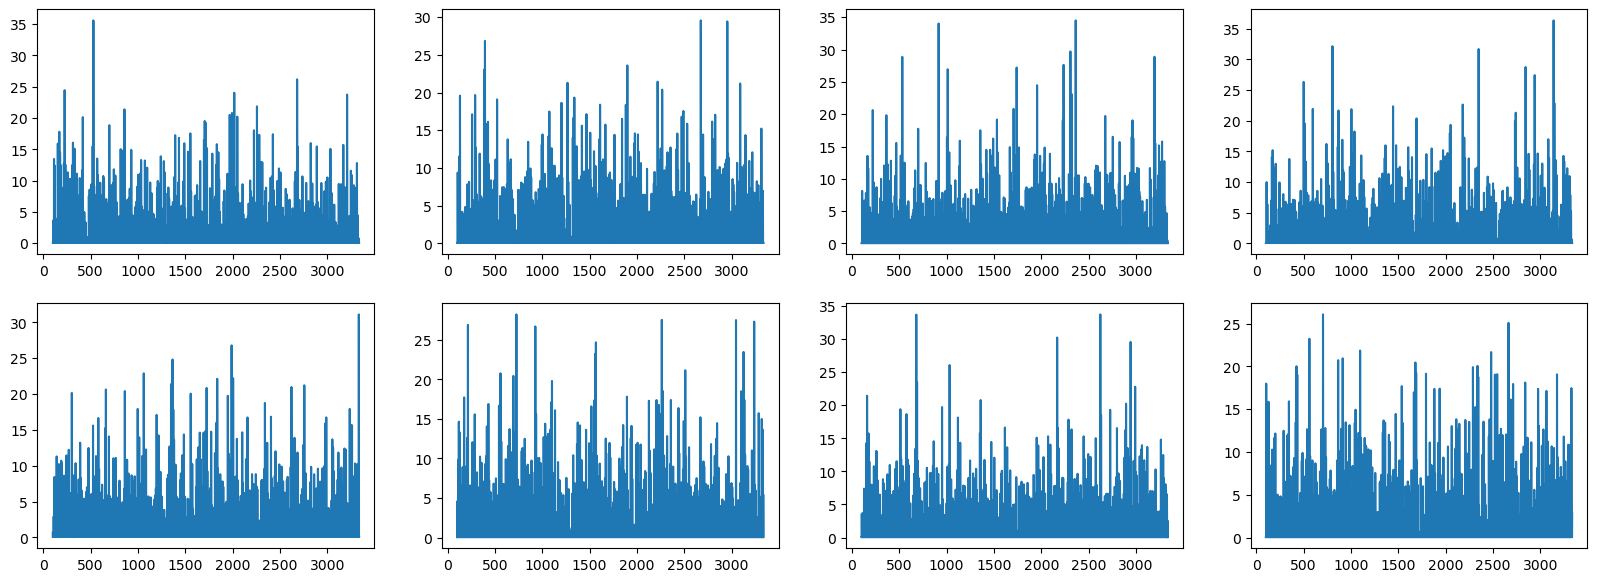

In [36]:
vis_mse(cs_mse)

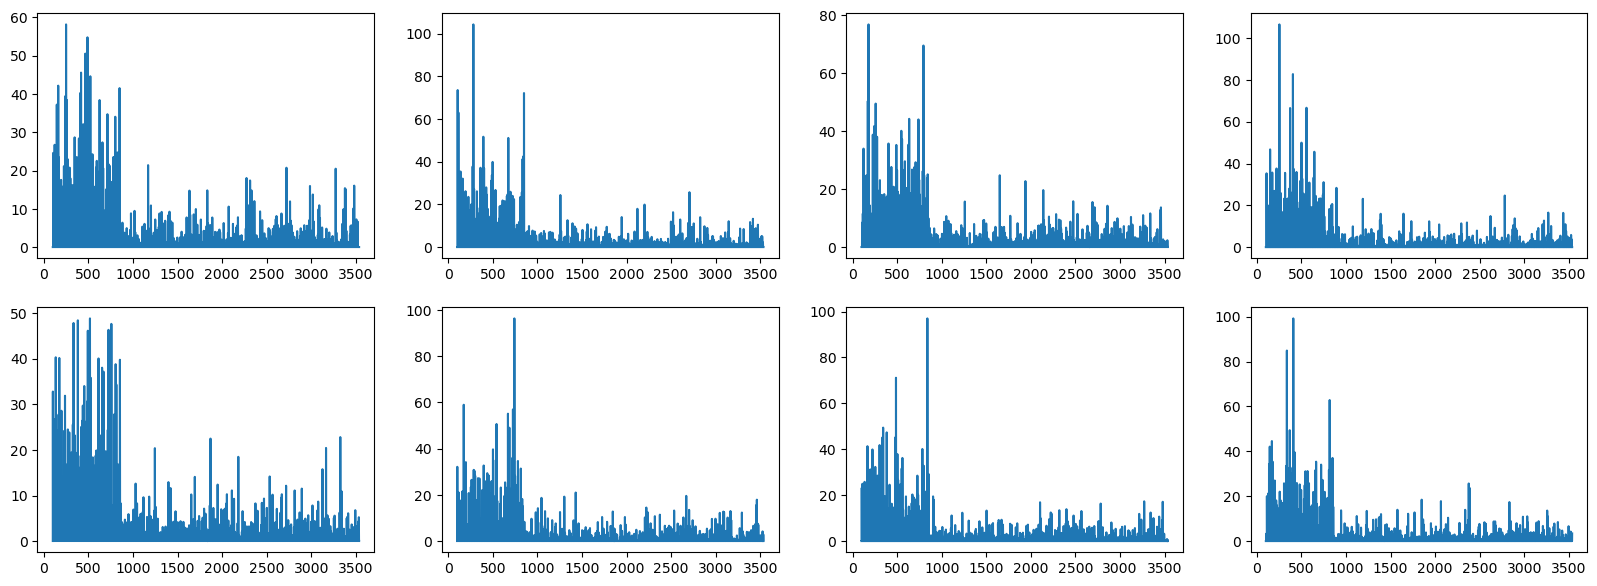

In [37]:
vis_mse(ds1_mse)

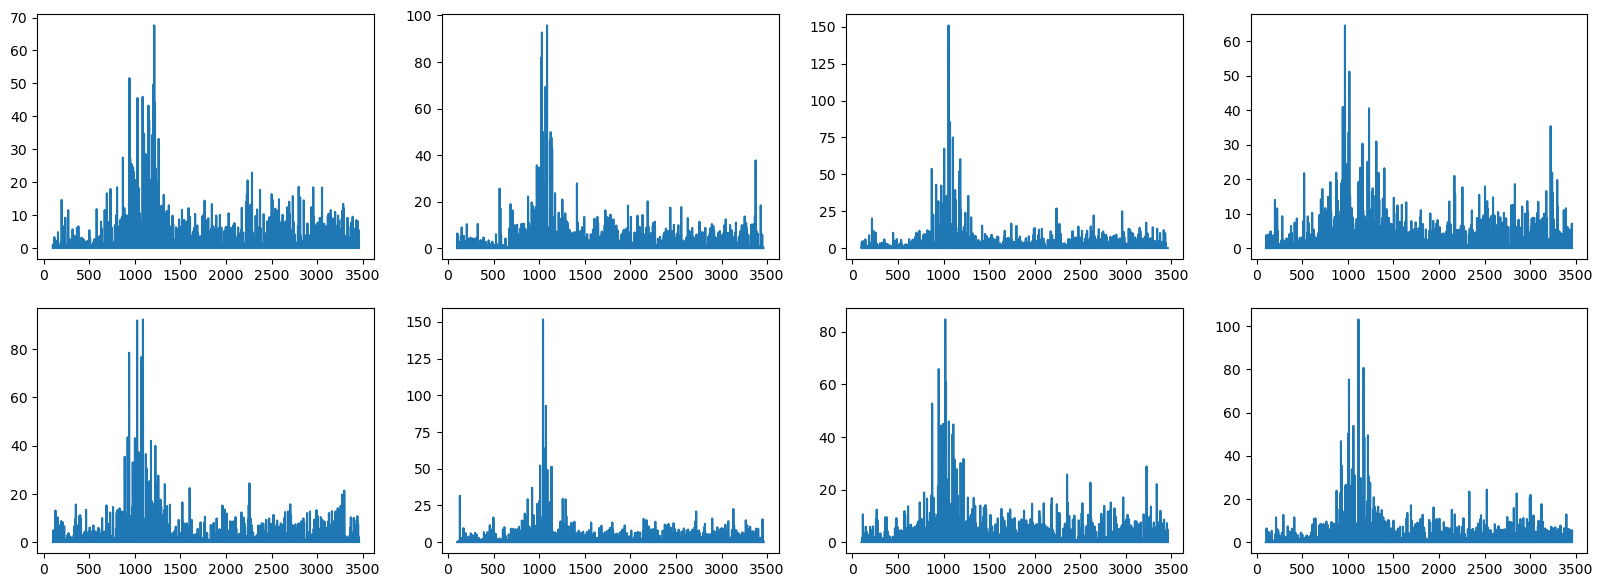

In [38]:
vis_mse(ds2_mse)

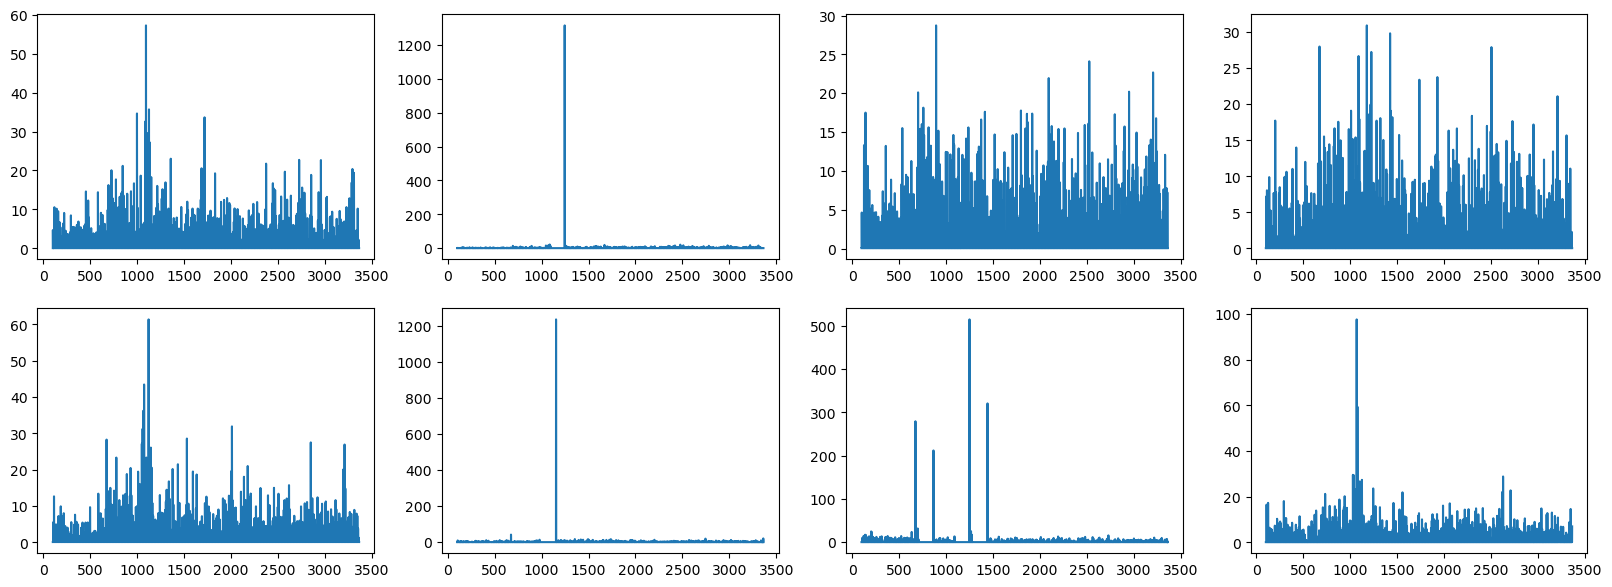

In [39]:
vis_mse(ds3_mse)

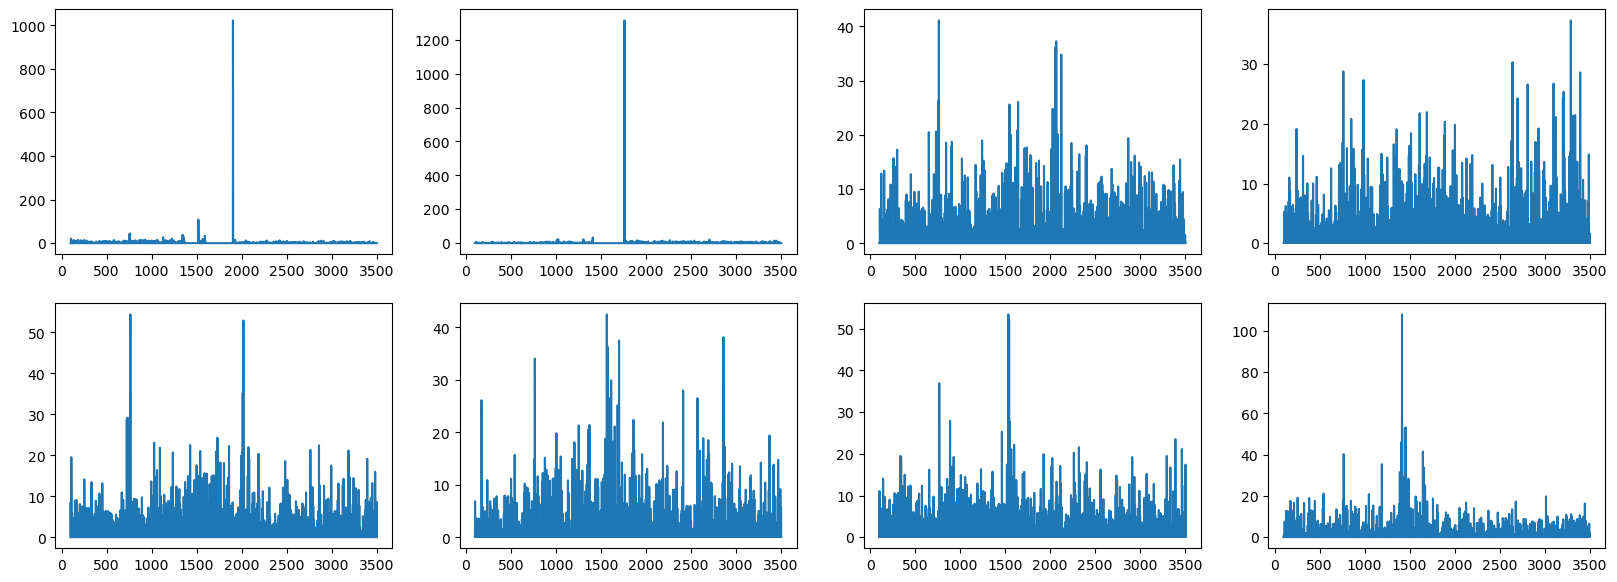

In [40]:
vis_mse(ds4_mse)

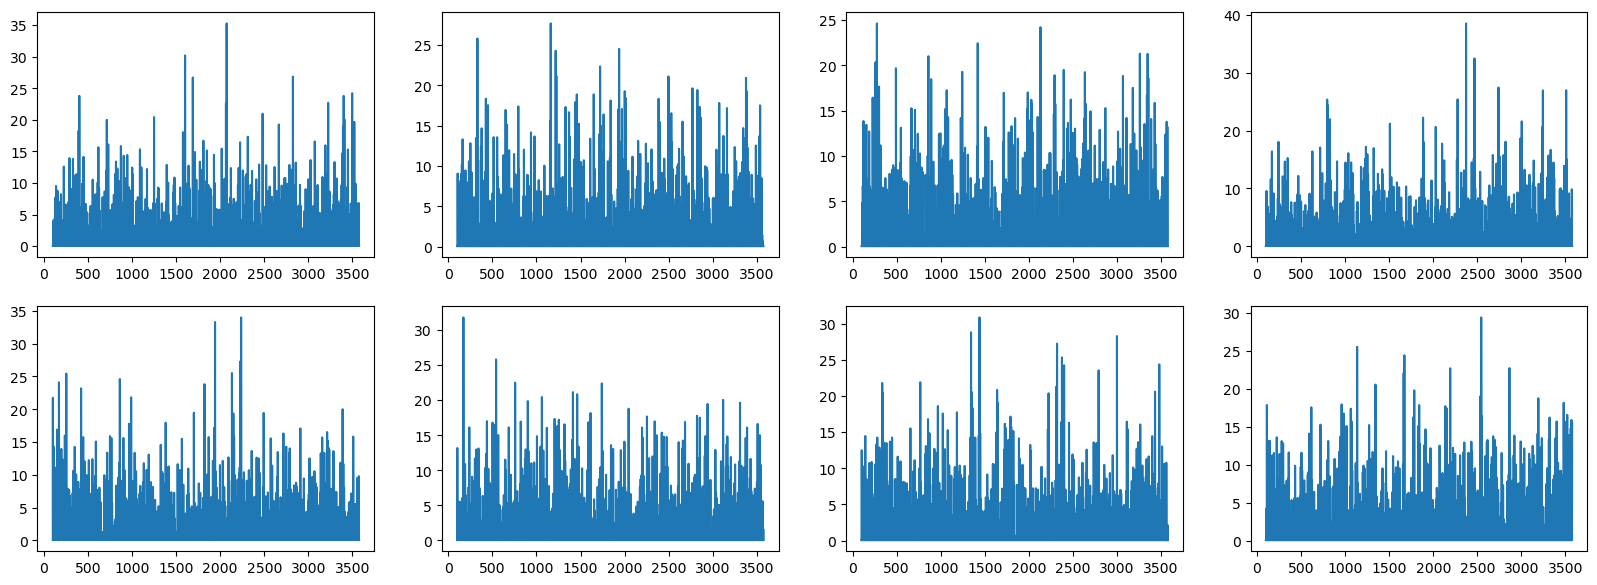

In [41]:
vis_mse(ds7_mse)

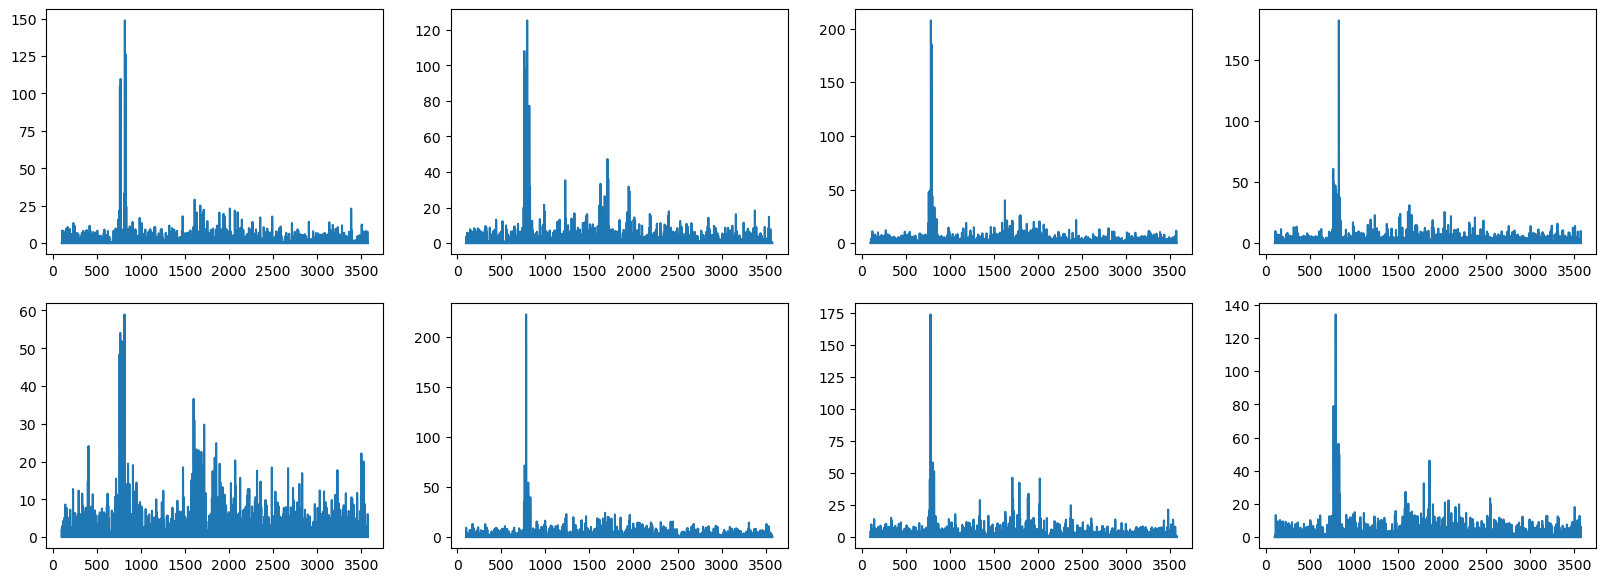

In [42]:
vis_mse(ds8_mse)

In [43]:
autoencoder.save('autoencoder_model.keras')

In [44]:
!tar -cvf autoencoder_model.tar autoencoder_model

a autoencoder_model
a autoencoder_model/keras_metadata.pb
a autoencoder_model/variables
a autoencoder_model/saved_model.pb
a autoencoder_model/variables/variables.data-00000-of-00001
a autoencoder_model/variables/variables.index


In [46]:
model = keras.models.load_model('autoencoder_model.keras')